## Imports

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Transform

In [13]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Load Dataset

In [14]:
# Load datasets
train_data = datasets.ImageFolder(root=r"D:/code/Cnn EEg/database/train/", transform=transform)
test_data = datasets.ImageFolder(root=r"D:/code/Cnn EEg/database/test/", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [15]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 588
    Root location: D:/code/Cnn EEg/database/train/
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Cnn


In [16]:
import torch.nn as nn
import torch.nn.functional as F


class SchizophreniaCNN(nn.Module):
    def __init__(self):
        super(SchizophreniaCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256, 1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 512)  # Adjusted value
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 2)

    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
        out = self.conv_layer2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.max_pool3(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)

        return out

## Load Params

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SchizophreniaCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1, Loss: 0.6994897603988648, Accuracy: 54.08163265306123
Acuracia das Imagens: 51.785714285714285 %
Epoch 2, Loss: 0.6690095841884613, Accuracy: 58.673469387755105
Acuracia das Imagens: 57.142857142857146 %
Epoch 3, Loss: 0.6692982077598572, Accuracy: 57.142857142857146
Acuracia das Imagens: 58.035714285714285 %
Epoch 4, Loss: 0.6674887537956238, Accuracy: 58.50340136054422
Acuracia das Imagens: 61.607142857142854 %
Epoch 5, Loss: 0.6523544490337372, Accuracy: 61.054421768707485
Acuracia das Imagens: 58.035714285714285 %
Epoch 6, Loss: 0.627334576845169, Accuracy: 62.925170068027214
Acuracia das Imagens: 52.67857142857143 %
Epoch 7, Loss: 0.6193883180618286, Accuracy: 64.96598639455782
Acuracia das Imagens: 56.25 %
Epoch 8, Loss: 0.6347464144229888, Accuracy: 64.28571428571429
Acuracia das Imagens: 60.714285714285715 %
Epoch 9, Loss: 0.6083544969558716, Accuracy: 65.98639455782313
Acuracia das Imagens: 60.714285714285715 %
Epoch 10, Loss: 0.595563530921936, Accuracy: 68.537414965

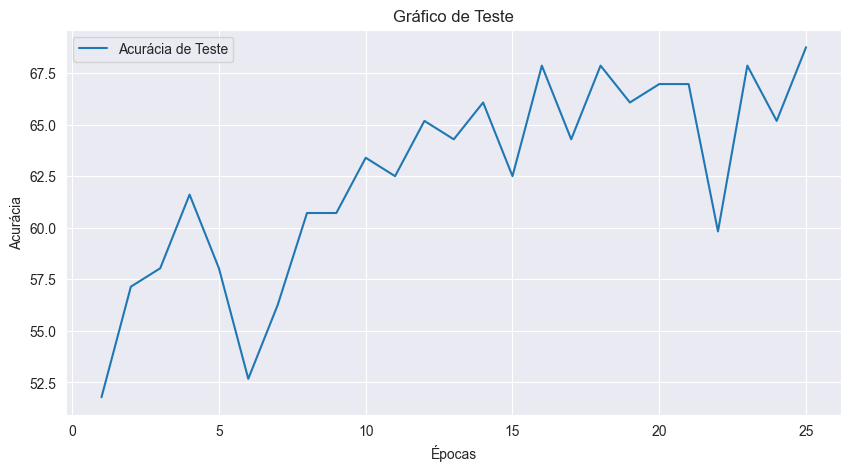

In [18]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []
true_labels = []
predicted_labels = []

# Training loop
epochs = 25
test_accu = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    scheduler.step()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {train_accuracy}")

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print(f'Acuracia das Imagens: {test_accuracy} %')
    test_accu += test_accuracy

# Plotting the accuracies
plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs + 1), train_accuracies, label='Acurácia de Treinamento')
plt.plot(range(1, epochs + 1), test_accuracies, label='Acurácia de Teste')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Gráfico de Teste')
plt.legend()
plt.show()

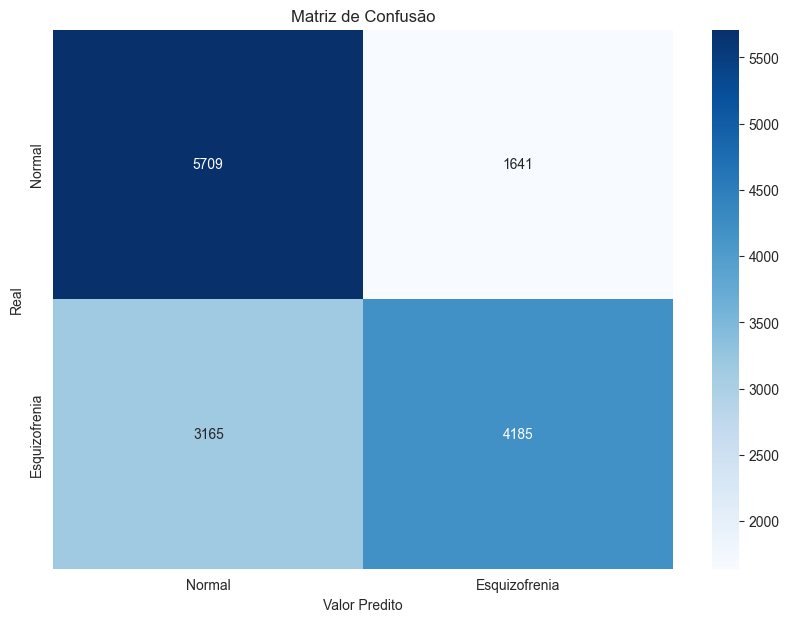

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Esquizofrenia'],
            yticklabels=['Normal', 'Esquizofrenia'])
plt.xlabel('Valor Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [20]:
# Import the calculate_precision function
from sklearn.metrics import precision_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f'Precision: {precision}')

Precision: 0.6808358557741787


In [21]:
from sklearn.metrics import recall_score

# Call the function and print the recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Recall: {recall}')

Recall: 0.6730612244897959


In [22]:
from sklearn.metrics import f1_score

# Call the function and print the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.6695090454942284
